In [ ]:
#@title Student Information
#@markdown Enter the following info and run the cell:
Name = "Ghazal ZamaniNejad" #@param {type:"string"}
StudentNumber = 97522166 #@param {type:"integer"}

#Imports

In [ ]:
%%capture
!pip install transformers

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import pandas as pd

from transformers import TFBertModel, BertTokenizer
%matplotlib inline

In [ ]:
!nvidia-smi # check if gpu mode is selected

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



We will use a dataset consists of questions where a previously given single supporting fact, potentially amongst a set of other irrelevant facts, provides the answer. We first test one of the simplest cases of this, by asking for the location of a person, e.g. “$Mary$ $travelled$ $to$ $the$ $office.$ $Where$ $is$ $Mary?$”. It can be considered the
simplest case of some real world QA datasets.

About the dataset: https://research.fb.com/downloads/babi/

Lets download the dataset:

# 1. LSTM- Q&A



## 1.2 Preprocessing

Our model takes a discrete set of inputs $x_{1}, ..., x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x_{i}$, $q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds a continuous representation for the $x$ and $q$. The continuous representation is then processed via multiple hops to
output $a$. This allows backpropagation of the error signal through multiple memory accesses back to the input during training. The overall model is shown in the next figure. During training, all three embedding matrices $A, B$ and $C$, as well as $W$ are jointly learned by minimizing a standard cross-entropy loss between $aˆ$ and the true
label $a$. Training is performed using stochastic gradient descent.


Delve more deeply into the details: https://arxiv.org/pdf/1503.08895.pdf

In [ ]:
%%capture
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xvzf babi_tasks_1-20_v1-2.tar.gz

In [ ]:
challenges = [
    'qa1_single-supporting-fact',
    'qa2_two-supporting-facts',
]
train_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_train.txt'
test_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_test.txt'

In [ ]:
def word_tokenizer(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x.strip()]

According to the dataset (bAbi tasks), we need to prepare the data for training the model. With the next function we parse the dataset and manufactore it in desired way.

In [ ]:
def parse_stories(lines, only_supporting=False, tokenize = True):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            if tokenize:
                q = word_tokenizer(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            if tokenize:
                sent = word_tokenizer(line)
            else:
                sent = line
            story.append(sent)
    return data


Now we need to take proper structure of the data: 

In [ ]:
def get_stories(f, only_supporting=False, max_length=None, tokenize=True):
    data = parse_stories(f.readlines(), only_supporting=only_supporting, tokenize=tokenize)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(story[0]+story[1], q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

Here we need to make the vectors of stories, questions and answers. its too easy:

In [ ]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
  
    ########################################
    #     Put your implementation here     #
    ########################################
    inputs_train = []
    queries_train = []
    answers_train = []

    for d in data:
      story, query, answer = d
      
      story_vec = np.zeros(story_maxlen)
      for i in range(len(story)):
        story_vec[i] = word_idx[story[i]]
      inputs_train.append(np.array(story_vec))

      query_vec = np.zeros(query_maxlen)
      for i in range(len(query)):
        query_vec[i] = word_idx[query[i]]
      queries_train.append(query_vec)
      
      ans_vec = np.zeros(len(word_idx) + 1)
      ans_num = word_idx[answer]
      ans_vec[ans_num] = 1
      answers_train.append(ans_vec)
      
    return np.array(inputs_train), np.array(queries_train), np.array(answers_train)

Its time to extract stories from the dataset, then pass them to the defined functions for parsing and make it usable:

In [ ]:
train_stories = get_stories(open(train_file_path), tokenize=True)
test_stories = get_stories(open(test_file_path), tokenize=True)

In [ ]:
len(train_stories), len(test_stories)

(10000, 1000)

## 1.3 Check our helper functions and prepare the data:

In [ ]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

In [ ]:
story_maxlen, query_maxlen

(14, 4)

In [ ]:
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)


-
Vocab size: 22 unique words
Story max length: 14 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [ ]:
inputs_train.shape, queries_train.shape, answers_train.shape

((10000, 14), (10000, 4), (10000, 22))

In [ ]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 14)
inputs_test shape: (1000, 14)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-
Compiling...


In this part you should implement 2 functions which illustrate the procedure of learning, Loss and Accuracy. These functions take two inputs: 
* The history of your designed model 
* Proper title for describing the plot

In [ ]:
def plot_acc(history, title):
  
  # This function should show not only the plot of accuracy on training and validation set
  # but also it should show the maximum value of accuracy with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################
  plt.plot(history.history['accuracy'],label="train_accuracy")
  plt.plot(history.history['val_accuracy'],label="validation_accuracy")
  plt.xlabel("epoch")
  plt.ylabel(title)
  plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_loss(history, title):
  
  # This function should show not only the plot of loss on training and validation set
  # but also it should show the minimum value of loss with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################
  plt.plot(history.history['loss'],label="train_loss")
  plt.plot(history.history['val_loss'],label="validation_loss")
  plt.xlabel("epoch")
  plt.ylabel(title)
  plt.legend()
  plt.tight_layout()
  plt.show()

Define model's hyperparameters

In [ ]:
train_epochs = 10
batch_size = 32
lstm_size = 32

## 1.4 Implementstion:

Let's build the model. You should use Keras framework. The summary and outview of the right model is saved in the next cells to help you create the proper model faster.


In [ ]:
from tensorflow.keras.layers import Embedding, Dot, Activation, Permute, Concatenate, LSTM, Dropout, Dense, Add
from tensorflow.keras import Sequential

# define the model: 
input_sequence = tf.keras.layers.Input((story_maxlen,))
question = tf.keras.layers.Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

########################################
#     Put your implementation here     #
########################################
sequential1 = Sequential([Embedding(vocab_size, 64)])(input_sequence)
sequential2 = Sequential([Embedding(vocab_size, 4)])(input_sequence)
sequential3 = Sequential([Embedding(vocab_size, 64)])(question)
dot = Dot(axes=(2, 2))([sequential1, sequential3])
activation = Activation('relu')(dot)
add = Add()([activation, sequential2])
permute = Permute((2, 1))(add)
concat = Concatenate()([permute, sequential3])
lstm = LSTM(lstm_size)(concat)
dropout = Dropout(0.1)(lstm)
dense = Dense(vocab_size)(dropout)
answer = Activation('softmax')(dense)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [ ]:
# build the final model
model = tf.keras.models.Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

The model architecture should look like this:

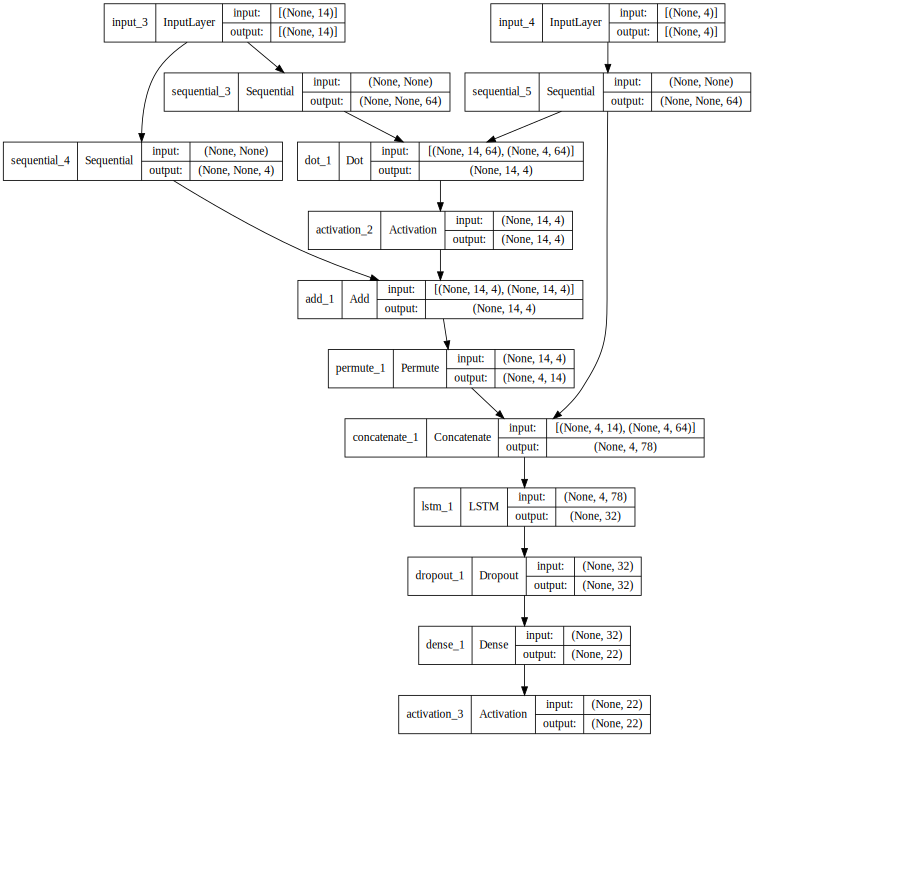

In [ ]:
from IPython.display import SVG

SVG(tf.keras.utils.model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

Model summary

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, None, 64)     1408        ['input_3[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, None, 64)     1408        ['input_4[0][0]']                
                                                                                            

## 1.5 Training

In this section we start the training procedure with fitting the data to the designed model.

Epoch 1/10
  1/313 [..............................] - ETA: 14s - loss: 1.7716 - accuracy: 0.1875

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 17s 55ms/step - loss: 1.8026 - accuracy: 0.1676 - val_loss: 1.7933 - val_accuracy: 0.1920
Epoch 2/10
313/313 [==============================] - 18s 57ms/step - loss: 1.7886 - accuracy: 0.1861 - val_loss: 1.7713 - val_accuracy: 0.2350
Epoch 3/10
313/313 [==============================] - 17s 53ms/step - loss: 1.7780 - accuracy: 0.2113 - val_loss: 1.7636 - val_accuracy: 0.2560
Epoch 4/10
313/313 [==============================] - 17s 53ms/step - loss: 1.7699 - accuracy: 0.2285 - val_loss: 1.7489 - val_accuracy: 0.2780
Epoch 5/10
313/313 [==============================] - 17s 55ms/step - loss: 1.7634 - accuracy: 0.2412 - val_loss: 1.7427 - val_accuracy: 0.2730
Epoch 6/10
313/313 [==============================] - 17s 53ms/step - loss: 1.7601 - accuracy: 0.2458 - val_loss: 1.7392 - val_accuracy: 0.2890
Epoch 7/10
313/313 [==============================] - 17s 54ms/step - loss: 1.7571 - accuracy: 0.2507 - val_loss: 1.7361 - val_accuracy: 0.2900
Epo

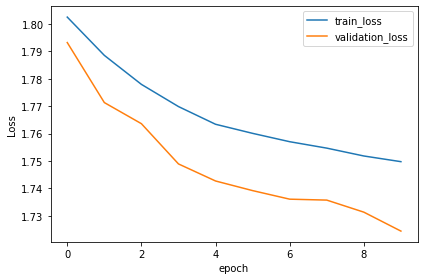

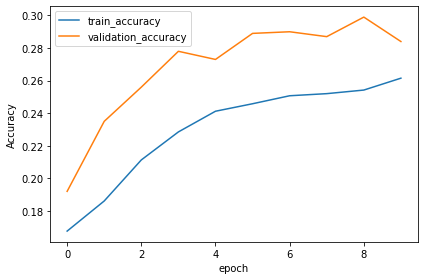

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

plot_loss(history,"Loss")
plot_acc(history,"Accuracy")

model.save('model.h5')

## 1.6 Testing and Analysis

Now we need to actually make predictions and check the performance of our trained model with some examples:

In [ ]:
for i in range(0,10):
    current_inp = test_stories[2*i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("-----------------------------------------------------------------------------------------")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: bathroom | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: hallway | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: hallway | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Truth: garden
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Truth:

## 1.7 Custom Inputs

You can even write your example and test it with your model to see how powerful it is:

In [ ]:
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')
while 1:
    print('-------------------------------------------------------------------------------------------')
    print('Please input a story')
    user_story_inp = input().split(' ')
    print('Please input a query')
    user_query_inp = input().split(' ')
    user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
    user_prediction = model.predict([user_story, user_query])
    user_prediction = idx_word[np.argmax(user_prediction)]
    print('Result')
    print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

-------------------------------------------------------------------------------------------
Custom User Queries (Make sure there are spaces before each word)
-------------------------------------------------------------------------------------------
Please input a story
Sandra travelled to the office . John journeyed to the garden .
Please input a query
Where is John ?


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Result
Sandra travelled to the office . John journeyed to the garden . Where is John ? | Prediction: garden
-------------------------------------------------------------------------------------------
Please input a story


KeyboardInterrupt: ignored

In [ ]:
# some examples:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .

As you understood how the model trained, please tell us about the pros and cons of the proposed model. How can we improve it if we want to use it in realistic task ? 

$\color{red}{\text{Write your answer in document}}$



#  2. Hands on SSL

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

## 2.1 prepare data

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


In [ ]:
unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [ ]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

In [ ]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


In [ ]:
print(x_unlabeld.shape)
print(x_train.shape)
print(y_train.shape)

(49800, 32, 32, 3)
(200, 32, 32, 3)
(200, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

# preprocess dataset
x_unlabeld_normalized = np.divide(x_unlabeld.astype('float32'), 255)
x_train_normalized = np.divide(x_train.astype('float32'), 255)
y_train_onehot = to_categorical(y_train, num_classes=10)

# preprocess trainset
x_test_normalized = np.divide(x_test.astype('float32'), 255)
y_test_onehot = to_categorical(y_test, num_classes=10)

In [ ]:
print(y_train_onehot.shape)
print(y_test_onehot.shape)

(200, 10)
(10000, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam

def convolutional(p):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(p))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(p))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(p))
  return model

In [ ]:
model1 = convolutional(0.2)
model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dense(10, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
opt = Adam(learning_rate=0.01)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(x_train_normalized, y_train_onehot, validation_data=(x_test_normalized, y_test_onehot), batch_size=64, epochs=100)

Epoch 1/100
4/4 [==============================] - 22s 7s/step - loss: 9.1873 - accuracy: 0.1600 - val_loss: 2402.4680 - val_accuracy: 0.0913
Epoch 2/100
4/4 [==============================] - 23s 7s/step - loss: 5.9166 - accuracy: 0.2000 - val_loss: 2992.3362 - val_accuracy: 0.1283
Epoch 3/100
4/4 [==============================] - 23s 8s/step - loss: 5.9463 - accuracy: 0.3150 - val_loss: 5952.2778 - val_accuracy: 0.1007
Epoch 4/100
4/4 [==============================] - 22s 7s/step - loss: 4.4410 - accuracy: 0.3350 - val_loss: 5850.2920 - val_accuracy: 0.0976
Epoch 5/100
4/4 [==============================] - 22s 7s/step - loss: 4.5020 - accuracy: 0.3000 - val_loss: 3503.3760 - val_accuracy: 0.0993
Epoch 6/100
4/4 [==============================] - 22s 7s/step - loss: 3.8864 - accuracy: 0.3250 - val_loss: 1447.0992 - val_accuracy: 0.1235
Epoch 7/100
4/4 [==============================] - 22s 7s/step - loss: 3.0249 - accuracy: 0.3850 - val_loss: 457.3521 - val_accuracy: 0.1105
Epoch 8

In [ ]:
model1.save("model1.h5")

In [ ]:
# Q4, part 2
def rotate(img, i):
  # rotate image i * 90 degree times
  y = np.zeros(4)
  x = np.rot90(img, k=i)
  y[i] = 1
  return x, y

def ssl_data(data):
  x_rotated = []
  y_rotated = []
  for d in data:
    for i in range(4):
      x, y = rotate(d, i)
      x_rotated.append(x)
      y_rotated.append(y)
    
  return x_rotated, y_rotated

x_rotated, y_rotated = ssl_data(x_unlabeld_normalized)

In [ ]:
x_rotated_arr = np.array(x_rotated)
y_rotated_arr = np.array(y_rotated)

# 4 train data for each image
print(x_rotated_arr.shape)
print(y_rotated_arr.shape)

(199200, 32, 32, 3)
(199200, 4)


In [ ]:
model2 = convolutional(0.2)
model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(4, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
opt2 = Adam(learning_rate=0.001)

model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(x_rotated_arr, y_rotated_arr, batch_size=256, epochs=15)

Epoch 1/15
779/779 [==============================] - 57s 58ms/step - loss: 0.9490 - accuracy: 0.6039
Epoch 2/15
779/779 [==============================] - 45s 58ms/step - loss: 0.7259 - accuracy: 0.7078
Epoch 3/15
779/779 [==============================] - 45s 57ms/step - loss: 0.6240 - accuracy: 0.7546
Epoch 4/15
779/779 [==============================] - 45s 58ms/step - loss: 0.5499 - accuracy: 0.7859
Epoch 5/15
779/779 [==============================] - 46s 59ms/step - loss: 0.4973 - accuracy: 0.8085
Epoch 6/15
779/779 [==============================] - 45s 58ms/step - loss: 0.4569 - accuracy: 0.8256
Epoch 7/15
779/779 [==============================] - 45s 57ms/step - loss: 0.4258 - accuracy: 0.8377
Epoch 8/15
779/779 [==============================] - 45s 57ms/step - loss: 0.4000 - accuracy: 0.8486
Epoch 9/15
779/779 [==============================] - 45s 57ms/step - loss: 0.3766 - accuracy: 0.8574
Epoch 10/15
779/779 [==============================] - 45s 57ms/step - loss: 0.358

In [ ]:
from keras.models import Model

new_layer = Dense(10 ,activation='softmax')(model2.layers[-2].output)
model2_2 = keras.Model(model2.inputs, new_layer)

In [ ]:
model2_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 32, 32, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0   

In [ ]:
model2_2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
model2_2.fit(x_train_normalized, y_train_onehot, batch_size=64, epochs=50)

Epoch 1/50
4/4 [==============================] - 1s 26ms/step - loss: 14.3403 - accuracy: 0.1050
Epoch 2/50
4/4 [==============================] - 0s 28ms/step - loss: 5.9600 - accuracy: 0.2150
Epoch 3/50
4/4 [==============================] - 0s 27ms/step - loss: 2.0161 - accuracy: 0.4300
Epoch 4/50
4/4 [==============================] - 0s 27ms/step - loss: 1.3006 - accuracy: 0.5200
Epoch 5/50
4/4 [==============================] - 0s 27ms/step - loss: 1.0979 - accuracy: 0.6200
Epoch 6/50
4/4 [==============================] - 0s 27ms/step - loss: 0.9804 - accuracy: 0.6750
Epoch 7/50
4/4 [==============================] - 0s 27ms/step - loss: 0.7257 - accuracy: 0.7700
Epoch 8/50
4/4 [==============================] - 0s 28ms/step - loss: 0.6137 - accuracy: 0.8100
Epoch 9/50
4/4 [==============================] - 0s 27ms/step - loss: 0.4860 - accuracy: 0.8300
Epoch 10/50
4/4 [==============================] - 0s 27ms/step - loss: 0.3491 - accuracy: 0.8900
Epoch 11/50
4/4 [===========

In [ ]:
from sklearn.utils import shuffle

# 200 images have class label, make rotations data too
x_labeled_rotated, y_labeled_rotated = ssl_data(x_train_normalized)
y_train_repeat = np.repeat(y_train, 4)
y_train_repeat_onehot = to_categorical(y_train_repeat, num_classes=10)
print(y_train_repeat_onehot.shape)

# make class label (tensor of zeros) for unlabeled data
y_unlabeld = np.zeros((x_unlabeld.shape[0]*4, 10))
print(y_unlabeld.shape)

# concatenate data
x_train_all = np.concatenate((x_labeled_rotated, x_rotated_arr))
y_train_class = np.concatenate((y_train_repeat_onehot, y_unlabeld))
y_train_rotation = np.concatenate((y_labeled_rotated, y_rotated_arr))


x_train_all, y_train_class, y_train_rotation = shuffle(x_train_all, y_train_class, y_train_rotation, random_state=20)
print(x_train_all.shape)
print(y_train_class.shape)
print(y_train_rotation.shape)

(800, 10)
(199200, 10)
(200000, 32, 32, 3)
(200000, 10)
(200000, 4)


In [ ]:
from keras.models import Model

base_model = convolutional(0.2)
f = Flatten()(base_model.layers[-1].output)
dense = Dense(128)(f)
class_number = Dense(10, name='class_num_output')(dense)

rotation_degree = Dense(4, name='rotation_degree_output')(dense)

model3 = Model(inputs=base_model.input,
               outputs = [class_number, rotation_degree])


model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_6_input (InputLayer)    [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['conv2d_6_input[0][0]']         
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization_6[0][0]

In [ ]:
model3.compile(optimizer=opt, 
               loss={
                   'class_num_output': 'categorical_crossentropy', 
                   'rotation_degree_output': 'categorical_crossentropy'},
               loss_weights={
                   'class_num_output': 2., 
                   'rotation_degree_output': 10.},
               metrics={
                   'class_num_output': 'accuracy',
                   'rotation_degree_output': 'accuracy'})

In [ ]:
r = 0
y_test_rotation = np.repeat(r, y_test.shape[0])
print(y_test_rotation.shape)
y_test_rotation = to_categorical(y_test_rotation, num_classes=4)
print(y_test_rotation.shape)

(10000,)
(10000, 4)


In [ ]:
history3 = model3.fit(x_train_all, [y_train_class, y_train_rotation], validation_data=(x_test_normalized, [y_test_onehot, y_test_rotation]), batch_size=256, epochs=10)

Epoch 1/10
782/782 [==============================] - 50s 62ms/step - loss: 77.5096 - class_num_output_loss: 0.0424 - rotation_degree_output_loss: 7.7425 - class_num_output_accuracy: 0.0011 - rotation_degree_output_accuracy: 0.2500 - val_loss: 64.1823 - val_class_num_output_loss: 11.2827 - val_rotation_degree_output_loss: 4.1617 - val_class_num_output_accuracy: 0.1000 - val_rotation_degree_output_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 48s 61ms/step - loss: 78.8335 - class_num_output_loss: 0.0451 - rotation_degree_output_loss: 7.8743 - class_num_output_accuracy: 4.0000e-04 - rotation_degree_output_accuracy: 0.2482 - val_loss: 93.3496 - val_class_num_output_loss: 11.2794 - val_rotation_degree_output_loss: 7.0791 - val_class_num_output_accuracy: 0.1000 - val_rotation_degree_output_accuracy: 0.0000e+00
Epoch 3/10
782/782 [==============================] - 48s 61ms/step - loss: 81.5652 - class_num_output_loss: 0.0441 - rotation_degree_output_loss: 8.1477 

In [ ]:
model3.compile(optimizer=opt, 
               loss={
                   'class_num_output': 'categorical_crossentropy', 
                   'rotation_degree_output': 'categorical_crossentropy'},
               loss_weights={
                   'class_num_output': 2., 
                   'rotation_degree_output': 5.},
               metrics={
                   'class_num_output': 'accuracy',
                   'rotation_degree_output': 'accuracy'})

In [ ]:
history3_2 = model3.fit(x_train_all, [y_train_class, y_train_rotation], validation_data=(x_test_normalized, [y_test_onehot, y_test_rotation]), batch_size=256, epochs=10)

Epoch 1/10
782/782 [==============================] - 61s 63ms/step - loss: 8.1395 - class_num_output_loss: 0.0327 - rotation_degree_output_loss: 1.6148 - class_num_output_accuracy: 0.0182 - rotation_degree_output_accuracy: 0.2387 - val_loss: 23.3255 - val_class_num_output_loss: 8.0250 - val_rotation_degree_output_loss: 1.4551 - val_class_num_output_accuracy: 0.0969 - val_rotation_degree_output_accuracy: 0.0443
Epoch 2/10
782/782 [==============================] - 49s 62ms/step - loss: 7.2024 - class_num_output_loss: 0.0322 - rotation_degree_output_loss: 1.4276 - class_num_output_accuracy: 0.3450 - rotation_degree_output_accuracy: 0.2550 - val_loss: 25.1403 - val_class_num_output_loss: 9.1235 - val_rotation_degree_output_loss: 1.3787 - val_class_num_output_accuracy: 0.1223 - val_rotation_degree_output_accuracy: 0.1527
Epoch 3/10
782/782 [==============================] - 48s 62ms/step - loss: 7.4030 - class_num_output_loss: 0.0338 - rotation_degree_output_loss: 1.4671 - class_num_outpu

In [ ]:
model3.compile(optimizer=opt, 
               loss={
                   'class_num_output': 'categorical_crossentropy', 
                   'rotation_degree_output': 'categorical_crossentropy'},
               loss_weights={
                   'class_num_output': 2., 
                   'rotation_degree_output': 0.5},
               metrics={
                   'class_num_output': 'accuracy',
                   'rotation_degree_output': 'accuracy'})

In [ ]:
history3_3 = model3.fit(x_train_all, [y_train_class, y_train_rotation], validation_data=(x_test_normalized, [y_test_onehot, y_test_rotation]), batch_size=256, epochs=10)

Epoch 1/10
782/782 [==============================] - 75s 81ms/step - loss: 4.1085 - class_num_output_loss: 0.0339 - rotation_degree_output_loss: 8.0816 - class_num_output_accuracy: 5.1000e-04 - rotation_degree_output_accuracy: 0.2523 - val_loss: 23.0698 - val_class_num_output_loss: 7.7657 - val_rotation_degree_output_loss: 15.0769 - val_class_num_output_accuracy: 0.1014 - val_rotation_degree_output_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 61s 78ms/step - loss: 4.1117 - class_num_output_loss: 0.0338 - rotation_degree_output_loss: 8.0881 - class_num_output_accuracy: 5.5000e-04 - rotation_degree_output_accuracy: 0.2520 - val_loss: 23.0811 - val_class_num_output_loss: 7.7657 - val_rotation_degree_output_loss: 15.0994 - val_class_num_output_accuracy: 0.1009 - val_rotation_degree_output_accuracy: 0.0000e+00
Epoch 3/10
782/782 [==============================] - 61s 78ms/step - loss: 4.1089 - class_num_output_loss: 0.0342 - rotation_degree_output_loss: 8.0812